<b>Importing the libraries

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import models,datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.utils import make_grid
from torchvision.datasets import STL10
import torch.optim as optim
from sklearn.metrics import confusion_matrix

<b>Downloading and defining Train & Test dataset

Transformation applied on Train & Test Data

In [ ]:
transform = transforms.Compose([
	transforms.Resize((255,255)),
  transforms.CenterCrop(224),
	transforms.ToTensor(),
  transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [ ]:
trainData = STL10('./data', split='train', transform=transform, download=True)
testData = STL10('./data', split='test', transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


<b>Exploring STL10 dataset

In [ ]:
print("Train Dataset Size: ", len(trainData))
print("Shape: ", trainData.data.shape)
print("Test Dataset Size: ", len(testData))

Train Dataset Size:  5000
Shape:  (5000, 3, 96, 96)
Test Dataset Size:  8000


In [ ]:
classes = trainData.classes
print("Number of classes = ", len(classes))
print(classes)

Number of classes =  10
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


Shape of an Image tensor from dataset

In [ ]:
image, label = trainData[0]
image.shape

torch.Size([3, 96, 96])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label (numeric): 0
Label (textual): airplane


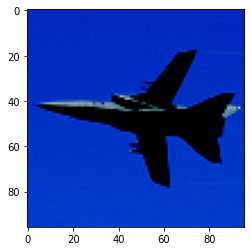

In [ ]:
image, label = trainData[200]
plt.imshow(image.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

<b>Number of images belonging to each class

In [ ]:
classCount = {}
for i,j in trainData: 
    labels = classes[j]
    if labels not in classCount:
        classCount[labels] = 0
    classCount[labels] += 1 
classCount 

{'airplane': 500,
 'bird': 500,
 'car': 500,
 'cat': 500,
 'deer': 500,
 'dog': 500,
 'horse': 500,
 'monkey': 500,
 'ship': 500,
 'truck': 500}

<b>Creating DataLoaders to load the data in batches

In [ ]:
batch_size = 64
trainLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True,num_workers=2,pin_memory =True)
testLoader = DataLoader(testData, batch_size=batch_size, shuffle=True,num_workers =2,pin_memory =True)

<b>Visualizing the Batch Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images Shape: torch.Size([128, 3, 96, 96])


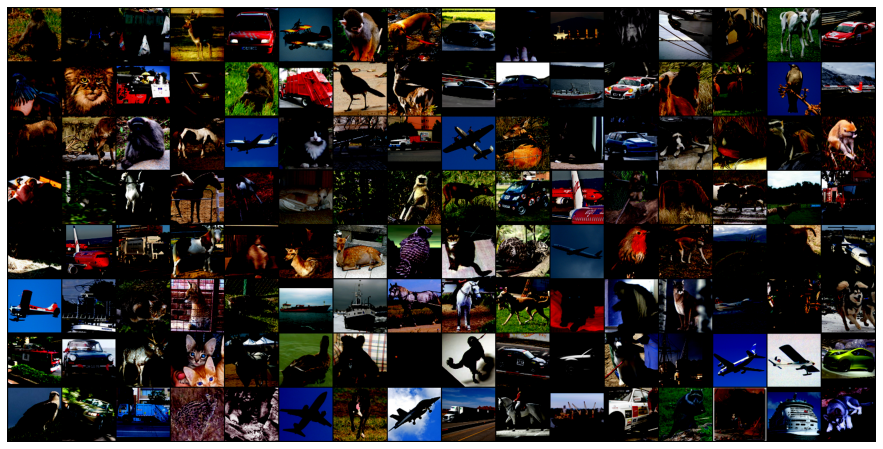

In [ ]:
for images, labels in trainLoader:
    print('Images Shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Moving data and labels to GPU if available

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

<b> Using Pretrained ResNet50 model

In [ ]:
model = models.resnet50(pretrained=True)
model = model.to(device)

summary(model, (3, 224, 224))


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<b>Loss Function and Optimizer

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
model.train()

#Number of epochs used =10
n_epochs = 10

for epoch in range(n_epochs):
  n_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)
        output_label = torch.argmax(output,dim=1)

        n_correct+= (labels==output_label).sum().item()

        optimizer.zero_grad()

        loss = loss_function(output, labels)
        r_loss += loss.item()*images.size(0)

        # Backward and optimize
        loss.backward()
        optimizer.step()

  print(f'Epoch:{epoch} Loss :{r_loss/len(trainData)}  Accuracy :{n_correct/len(trainData)*100}%')
print("Training Completed")

Epoch:0 Loss :0.4143375564575195  Accuracy :86.22%
Epoch:1 Loss :0.3909635817050934  Accuracy :86.58%
Epoch:2 Loss :0.35899941387176515  Accuracy :87.78%
Epoch:3 Loss :0.33619474449157716  Accuracy :88.92%
Epoch:4 Loss :0.3375133812904358  Accuracy :88.52%
Training Completed



<b> Calculating Accuracy  before Fine Tunning for different classses on the ResNet50 model for Test Data

In [ ]:
correct_predction = {label: 0 for label in classes}
total_predction = {label: 0 for label in classes}

with torch.no_grad():
  model.eval()
  n_correct=0.0

  for images, labels in testLoader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        output_labels = torch.argmax(outputs,dim=1)

        n_correct += sum(labels==output_labels)

        #Checking Classwise Correct Prediction
        for j in range(batch_size):
          if labels[j] == output_labels[j]:
                correct_predction[classes[labels[j]]] += 1
              
          total_predction[classes[labels[j]]] += 1

print(f'Accuracy on test data: {100 * n_correct // len(testData)} %')

for label, correct_count in correct_predction.items():
    print("Accuracy for Class : ",label," is ",str(round(100 * (float(correct_count) / total_predction[label]),2)),"%",sep=" ")

Accuracy on test data: 82.0 %
Accuracy for Class :  airplane  is  84.25 %
Accuracy for Class :  bird  is  86.75 %
Accuracy for Class :  car  is  82.38 %
Accuracy for Class :  cat  is  77.75 %
Accuracy for Class :  deer  is  78.5 %
Accuracy for Class :  dog  is  71.88 %
Accuracy for Class :  horse  is  84.0 %
Accuracy for Class :  monkey  is  81.5 %
Accuracy for Class :  ship  is  90.75 %
Accuracy for Class :  truck  is  84.5 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


<b> Fine Tune the ResNet50 model

In [ ]:
tuned_model1 = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   

tuned_model1.avg_pool = nn.AdaptiveAvgPool2d(1)
tuned_model1.fc = nn.Sequential(
    nn.BatchNorm1d(2048),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=2048, out_features=2048),
    nn.ReLU(),
    nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=10),
).to(device)

In [ ]:
summary(tuned_model1, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(tuned_model1.fc.parameters())

<b> Training the Fine tuned ResNet50 model

In [ ]:
tuned_model1.train()

num_epochs = 10
for epoch in range(num_epochs):
  total_correct =0.0
  r_loss=0.0

  for i, (images, labels) in enumerate(trainLoader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = tuned_model1(images)

        output_label = torch.argmax(outputs,dim=1)
        total_correct+= (labels==output_label).sum().item()

        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        r_loss += loss.item()*images.size(0)

        # Backward and optimize
        loss.backward()
        optimizer.step()
  print(f'Epoch: {epoch} Loss :{r_loss/len(trainData)}  Accuracy :{total_correct/len(trainData)*100}%')
print("Finished Training")

Epoch: 0 Loss :0.2538050718545914  Accuracy :92.34%
Epoch: 1 Loss :0.12460703556537628  Accuracy :95.74000000000001%
Epoch: 2 Loss :0.09275018665790558  Accuracy :97.06%
Epoch: 3 Loss :0.06733751568389125  Accuracy :97.56%
Epoch: 4 Loss :0.048290332701802254  Accuracy :98.34%
Epoch: 5 Loss :0.0700740644901991  Accuracy :97.46000000000001%
Epoch: 6 Loss :0.060362133127450944  Accuracy :98.14%
Epoch: 7 Loss :0.05540539839863777  Accuracy :98.02%
Epoch: 8 Loss :0.048702784439921376  Accuracy :98.42%
Epoch: 9 Loss :0.04847560664564371  Accuracy :98.36%
Finished Training


<b> Calculating Accuracy for different classses on the fine tuned ResNet50 model for Test Data

In [ ]:
correct_predction = {label: 0 for label in classes}
total_predction = {label: 0 for label in classes}
confusion_matrix = torch.zeros(len(classes), len(classes))


with torch.no_grad():
  tuned_model1.eval()
  n_correct=0.0

  for images, labels in testLoader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = tuned_model1(images)
        output_labels = torch.argmax(outputs,dim=1)

        n_correct += sum(labels==output_labels)

        #Confusion matrix
        for t, p in zip(labels.view(-1), output_labels.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        #Checking Classwise Correct Prediction
        for j in range(batch_size):
          if labels[j] == output_labels[j]:
                correct_predction[classes[labels[j]]] += 1
              
          total_predction[classes[labels[j]]] += 1

print(f'Accuracy on test data: {100 * n_correct // len(testData)} %')

for label, correct_count in correct_predction.items():
    print("Accuracy for Class : ",label," is ",str(round(100 * (float(correct_count) / total_predction[label]),2)),"%",sep=" ")

print(confusion_matrix)

Accuracy on test data: 95.0 %
Accuracy for Class :  airplane  is  97.5 %
Accuracy for Class :  bird  is  97.38 %
Accuracy for Class :  car  is  97.38 %
Accuracy for Class :  cat  is  95.88 %
Accuracy for Class :  deer  is  92.62 %
Accuracy for Class :  dog  is  91.75 %
Accuracy for Class :  horse  is  95.25 %
Accuracy for Class :  monkey  is  97.75 %
Accuracy for Class :  ship  is  95.62 %
Accuracy for Class :  truck  is  97.75 %
tensor([[780.,   8.,   0.,   1.,   1.,   0.,   1.,   0.,   2.,   7.],
        [  0., 779.,   0.,   3.,   0.,   1.,   2.,  15.,   0.,   0.],
        [  3.,   0., 779.,   1.,   0.,   0.,   0.,   0.,   0.,  17.],
        [  0.,   6.,   0., 767.,   9.,  11.,   2.,   5.,   0.,   0.],
        [  2.,   8.,   1.,  26., 741.,   6.,  16.,   0.,   0.,   0.],
        [  1.,   6.,   0.,  35.,   4., 734.,  11.,   6.,   1.,   2.],
        [  0.,   1.,   0.,   4.,  18.,  10., 762.,   4.,   0.,   1.],
        [  0.,   4.,   0.,   5.,   5.,   1.,   2., 782.,   1.,   0.],
      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
